In [1]:
import nltk; nltk.download('stopwords')
import re
import numpy as np
import pandas as pd
from pprint import pprint
import os
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from nltk import *
%matplotlib inline  

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.parsing.porter import PorterStemmer


# spacy for lemmatization
import spacy



from nltk.corpus import stopwords 
stop_words= stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

threshold_frequency_lemmatization=30
threshold_frequency_stemming=20

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/amirraza/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
folder='Downloads/rt-polaritydata/rt-polaritydata'
list_files= sorted(os.listdir(folder))
print(list_files)

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations



['.DS_Store', 'rt-polarity.neg', 'rt-polarity.pos']


In [3]:
data_collect={}
for file_name in list_files:
    if 'rt' in file_name:
        key=file_name.split('.')[1]
        print(file_name)
        f=open(folder+'/'+file_name,'r', encoding = "ISO-8859-1")
        content= f.read()
        f.close()
        data= content.splitlines()
        print('length of data:' ,len(data))
        data = [re.sub('\s+', ' ', sent) for sent in data]
        data = [re.sub("\'", "", sent) for sent in data]
        data_words = list(sent_to_words(data))
        data_words= [j for sub in data_words for j in sub]
        data_collect[key]=data_words


rt-polarity.neg
length of data: 5349
rt-polarity.pos
length of data: 5346


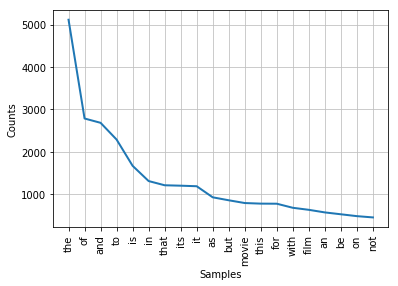

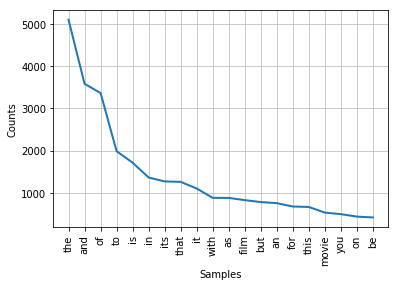

In [4]:
#frequency distribution of words
freqDist_neg = FreqDist(data_collect['neg'])
freqDist_pos= FreqDist(data_collect['pos'])

freqDist_neg.plot(20)
freqDist_pos.plot(20)

#Doesn't look like the most useful information. Lots of stopwords are present, which we will choose to remove 

57349
58194


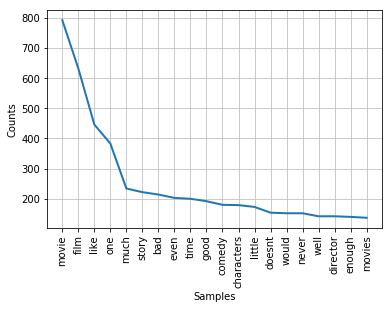

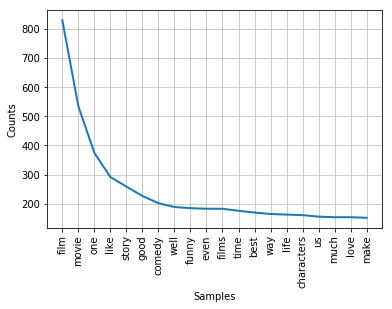

In [5]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

data_collect_removed_stopwords={}
for key in data_collect:
    data_removed_stopwords= remove_stopwords(data_collect[key])
    data_removed_stopwords= [j for sub in data_removed_stopwords for j in sub]
    data_collect_removed_stopwords[key]=data_removed_stopwords

#frequency distribution of words after stopwords removal
freqDist_neg = FreqDist(data_collect_removed_stopwords['neg'])
freqDist_pos= FreqDist(data_collect_removed_stopwords['pos'])
print(len(data_collect_removed_stopwords['neg']))
print(len(data_collect_removed_stopwords['pos']))
freqDist_neg.plot(20)
freqDist_pos.plot(20)


Question:Experiment with whether to lemmatize or stem, and whether to include stopwords. NLTK includes implementations of lemmatizers and stemmers for English, as well as stopword lists. Features should
be unigram counts.
Answer: As we saw, removal of stopwords is better to get more useful features

In [6]:

#doing lemmatisation on stopwords removed data
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer() 
  
#after only lemmatizaton    
data_collect_lemmatization={}
for key in data_collect:
    data_lemmatized= [lemmatizer.lemmatize(d) for d in data_collect_removed_stopwords[key]]
    data_collect_lemmatization[key]=data_lemmatized
    

freqDist_neg = FreqDist(data_collect_lemmatization['neg'])
freqDist_pos= FreqDist(data_collect_lemmatization['pos'])

print(len(data_collect_lemmatization['neg']))
print(len(data_collect_lemmatization['pos']))


57349
58194


In [7]:
#doing only stemming after stopwords removal on data
data_collect_stemmed={}
p = PorterStemmer()
for key in data_collect:
    data_stemmed= [p.stem(d) for d in data_collect_lemmatization[key]]
    data_collect_stemmed[key]=data_stemmed
    
freqDist_neg = FreqDist(data_collect_stemmed['neg'])
freqDist_pos= FreqDist(data_collect_stemmed['pos'])

print(len(data_collect_stemmed['neg']))
print(len(data_collect_stemmed['pos']))


57349
58194


Also, remove infrequently occurring
words as features. You may tune the threshold at which to remove infrequent words. You can also
experiment with the amount of smoothing/regularization in training the models to achieve better results.

In [8]:
#lemmatization
threshold_frequency_lemmatization=[1,10,20,30,40,100]

for t in threshold_frequency_lemmatization:
    data_collect_lemmatization['neg'] = [x for x in data_collect_lemmatization['neg'] if freqDist_neg[x]>t]
    data_collect_lemmatization['pos'] = [x for x in data_collect_lemmatization['pos'] if freqDist_pos[x]>t]



    vectorizer = CountVectorizer()
    # tokenize and build vocab
    #vocab should be same across both set of documents. Hence combining the two to get the vocab.
    z=[]
    print(len(data_collect_lemmatization['neg']))
    print(len(data_collect_lemmatization['pos']))
    z= data_collect_lemmatization['neg'][:]
    z.extend(data_collect_lemmatization['pos'])
    
    print(len(z))
    print(len(data_collect_lemmatization['neg']))
    
    
    vectorizer.fit(z)
    # summarize
    # encode document
    vector = vectorizer.transform(z)

    print(type(vector))
    print(vector.shape)
    print(vector.toarray())
    #print(vectorizer.vocabulary_)

    vector_neg = vectorizer.transform(data_collect_lemmatization['neg'])
    vector_pos = vectorizer.transform(data_collect_lemmatization['pos'])

    print(np.nonzero(vector_neg))

    from sklearn.model_selection import train_test_split
    Y= [0 for j in range(vector_neg.shape[0])]
    for i in range(vector_pos.shape[0]):
        Y.append(1)
    from scipy.sparse import  vstack

    X = vstack((vector_neg,vector_pos))
    X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0)

    #for (lemmatization)
    from sklearn.naive_bayes import GaussianNB
    gnb = GaussianNB()
    y_pred = gnb.fit(X_train.toarray(),y_train).predict(X_test.toarray())

    print('Chosen threshold frequency:' ,t)

    from sklearn.metrics import accuracy_score
    print('Naive bayes with lemmatization',accuracy_score(y_test, y_pred))

    from sklearn.metrics import confusion_matrix
    print(confusion_matrix(y_test, y_pred))

    print('--------------------')
    from sklearn.linear_model import LogisticRegression
    lgr = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial').fit(X_train.toarray(), y_train)
    y_pred_lgr= lgr.predict(X_test.toarray())
    print('logistic regression lemmatization',accuracy_score(y_test, y_pred_lgr))
    print(confusion_matrix(y_test, y_pred_lgr))
    print('------------------------------------')

    #SVM
    from sklearn import linear_model
    from sklearn.svm import SVC
    svclassifier = SVC(kernel='linear')
    svclassifier.fit(X_train, y_train)

    y_pred_svm= svclassifier.predict(X_test.toarray())

    print('SVM with lemmatization',accuracy_score(y_test, y_pred_svm.round()))
    print(confusion_matrix(y_test, y_pred_svm))
    print('------------------------------------')




29704
29262
58966
29704
<class 'scipy.sparse.csr.csr_matrix'>
(58966, 3859)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(array([    0,     1,     2, ..., 29701, 29702, 29703], dtype=int32), array([3393,  719, 1187, ..., 3724, 1977,  980], dtype=int32))
Chosen threshold frequency: 1
Naive bayes with lemmatization 0.5772622439289106
[[2081 5269]
 [ 963 6429]]
--------------------


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


logistic regression lemmatization 0.6107041107041107
[[4727 2623]
 [3116 4276]]
------------------------------------
SVM with lemmatization 0.6113146113146113
[[4747 2603]
 [3127 4265]]
------------------------------------
21614
21421
43035
21614
<class 'scipy.sparse.csr.csr_matrix'>
(43035, 921)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(array([    0,     1,     2, ..., 21611, 21612, 21613], dtype=int32), array([145, 267, 183, ..., 880, 453, 208], dtype=int32))
Chosen threshold frequency: 10
Naive bayes with lemmatization 0.5999628218235895
[[1814 3581]
 [ 723 4641]]
--------------------


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


logistic regression lemmatization 0.6344455804442792
[[3253 2142]
 [1791 3573]]
------------------------------------
SVM with lemmatization 0.6344455804442792
[[3253 2142]
 [1791 3573]]
------------------------------------
17384
17522
34906
17384
<class 'scipy.sparse.csr.csr_matrix'>
(34906, 476)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(array([    0,     1,     2, ..., 17381, 17382, 17383], dtype=int32), array([ 68, 139, 465, ..., 434, 447, 236], dtype=int32))
Chosen threshold frequency: 20
Naive bayes with lemmatization 0.5791222642374241
[[4153  173]
 [3500  901]]
--------------------


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


logistic regression lemmatization 0.6317176578434742
[[2570 1756]
 [1458 2943]]
------------------------------------
SVM with lemmatization 0.6317176578434742
[[2570 1756]
 [1458 2943]]
------------------------------------
15057
15128
30185
15057
<class 'scipy.sparse.csr.csr_matrix'>
(30185, 312)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(array([    0,     1,     2, ..., 15054, 15055, 15056], dtype=int32), array([ 42,  83, 306, ..., 284, 293, 153], dtype=int32))
Chosen threshold frequency: 30
Naive bayes with lemmatization 0.5885782430104677
[[3374  347]
 [2758 1068]]
--------------------
logistic regression lemmatization 0.6360143103219822
[[2225 1496]
 [1251 2575]]
------------------------------------
SVM with lemmatization 0.6360143103219822
[[2225 1496]
 [1251 2575]]
------------------------------------
12975
12968
25943
12975
<class 'scipy.sparse.csr.csr_matrix'>
(25943, 217)
[[0 0 0 ... 0 0 0]
 [0 0 0 .

In [9]:
#with stemming

threshold_frequency_stemming=[1,10,20,30,40,100]

for t in threshold_frequency_stemming:

    data_collect_stemmed['neg'] = [x for x in data_collect_stemmed['neg'] if freqDist_neg[x]>t]
    data_collect_stemmed['pos'] = [x for x in data_collect_stemmed['pos'] if freqDist_pos[x]>t]



    vectorizer = CountVectorizer()
    # tokenize and build vocab
    #vocab should be same across both set of documents. Hence combining the two to get the vocab.
    z=[]
    print(len(data_collect_stemmed['neg']))
    print(len(data_collect_stemmed['pos']))
    z= data_collect_stemmed['neg'][:]
    z.extend(data_collect_stemmed['pos'])

    vectorizer.fit(z)
    # summarize
    # encode document
    vector = vectorizer.transform(z)

    print(type(vector))
    print(vector.shape)
    print(vector.toarray())

    vector_neg = vectorizer.transform(data_collect_lemmatization['neg'])
    vector_pos = vectorizer.transform(data_collect_lemmatization['pos'])

    print(np.nonzero(vector_neg))

    print('Chosen threshold frequency ', t)

    
    X = vstack((vector_neg,vector_pos))
    X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0)
    gnb = GaussianNB()
    y_pred = gnb.fit(X_train.toarray(),y_train).predict(X_test.toarray())

    print('Naive bayes for stemmed',accuracy_score(y_test, y_pred))

    confusion_matrix(y_test, y_pred)

    print('----------------------------')
    #Logistic Regression
    lgr = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial').fit(X_train.toarray(), y_train)
    y_pred_lgr= lgr.predict(X_test.toarray())
    print('logistic regression stemmed',accuracy_score(y_test, y_pred_lgr))
    print(confusion_matrix(y_test, y_pred_lgr))

    print('--------------------')
    #SVM
    svclassifier = SVC(kernel='linear')
    svclassifier.fit(X_train, y_train)

    y_pred_svm= svclassifier.predict(X_test.toarray())

    print('SVM with stemming',accuracy_score(y_test, y_pred_svm.round()))
    print(confusion_matrix(y_test, y_pred_svm))
    print('----------------------------')




53212
54264
<class 'scipy.sparse.csr.csr_matrix'>
(107476, 6772)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(array([   0,    1,    2, ..., 6301, 6302, 6303], dtype=int32), array([1261, 6705, 3583, ..., 3563, 6584, 3563], dtype=int32))
Chosen threshold frequency  1
Naive bayes for stemmed 0.6676291305742701
----------------------------
logistic regression stemmed 0.6974655117099775
[[ 982  567]
 [ 376 1192]]
--------------------
SVM with stemming 0.6974655117099775
[[ 982  567]
 [ 376 1192]]
----------------------------
37650
38777
<class 'scipy.sparse.csr.csr_matrix'>
(76427, 1450)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(array([   0,    1,    2, ..., 6301, 6302, 6303], dtype=int32), array([ 245, 1431,  748, ...,  742, 1398,  742], dtype=int32))
Chosen threshold frequency  10
Naive bayes for stemmed 0.6676291305742701
-------------

In [12]:
#random model for baseline accuracy
import random 

y_pred_randpm=[]
for i in range(X_test.shape[0]):
    y=random.randint(0, 1)
    y_pred_randpm.append(y)
accuracy_score(y_test, y_pred_randpm)
#random baselines
from sklearn.metrics import confusion_matrix
print(accuracy_score(y_test, y_pred_randpm))
print(confusion_matrix(y_test, y_pred_randpm))




0.5117099775425088
[[789 760]
 [762 806]]


Compare
the logistic regression, support vector machine (with a linear kernel), and Naive Bayes algorithms.
Also,compare against the expected performance of a random baseline, which just guesses positive or negative
with equal probability